import data and inspect

In [1]:
import pandas as pd
import numpy as np

In [ ]:
#C:\Users\Acer\Documents\DataSprint\data\DataWaveDataSet.csv
file = r"C:\Users\Acer\Documents\DataSprint\data\DataWaveDataSet.csv"

df = pd.read_csv(file)

df.head()
df.info()
df.shape
df.describe()


df.isnull().sum()

Cleaning the user_id

In [ ]:
df['user_id'].duplicated().sum()

df = df.drop_duplicates(subset=['user_id'])

df = df.dropna(subset=['user_id'])


cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)


save the new csv


In [20]:
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)

In [2]:
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df = pd.read_csv(cleaned_file)

cleaning the gender and country column

In [ ]:
df = pd.read_csv(cleaned_file)

df ['gender'].isnull().sum()

#dropping the null values
df = df.dropna(subset=['gender'])

df['gender'] = df['gender'].astype(str).str.lower().str.strip()

gender_map = {
    'f' : 'Female',
    'female': 'Female',

    'm' : 'Male',
    'male': 'Male',

    'other' : 'Other'
}

df['gender'] = df['gender'].map(gender_map)


df['country'].isnull().sum()

df['country'] = (df['country'].astype(str).str.lower().str.strip().str.replace('.', '', regex = False))

country_map = {
    'uk' : 'United Kingdom',
    'united kingdom' : 'United Kingdom',
    'usa' : 'United States',
    'ind' : 'India',
}

df['country'] = df['country'].map(country_map).fillna(df['country'])
df['country'] = df['country'].str.title()




In [23]:
# df = pd.read_csv(cleaned_file)
cleaned_file = r"C:\Users\Acer\Documents\DataSprint\data\cleaned.csv"
df.to_csv(cleaned_file, index=False)


subscription_type cleaning

In [ ]:
df['subscription_type'].unique()

df['subscription_type'] = (df['subscription_type'].astype(str).str.lower().str.strip())

subscription_map = {
    'studnt' : 'student',
    'fam' : 'family',
    'premum' : 'premium',
}

df['subscription_type'] = df['subscription_type'].map(subscription_map).fillna(df['subscription_type'])
df['subscription_type'] = df['subscription_type'].str.title()



array(['Premium', 'Student', 'Family', 'Free'], dtype=object)

Inspect and cleaning satisfaction_score & skip rate

In [5]:
df = df.dropna(subset=['satisfaction_score'])



In [ ]:
def clean_skip_rate(x):
    x = str(x).strip().lower()

    if "%" in x:
        x = x.replace("%", "")
        return pd.to_numeric(x, errors="coerce") / 100

    num = pd.to_numeric(x, errors="coerce")
    if pd.notna(num):
        return num

    words = {
        "zero": 0,
        "one": 1,
        "two": 2,
        "three": 3,
        "four": 4,
        "five": 5,
        "six": 6,
        "seven": 7,
        "eight": 8,
        "nine": 9,
        "ten": 10
    }

    if x in words:
        return words[x]

    return np.nan


df["skip_rate"] = df["skip_rate"].apply(clean_skip_rate)

df["skip_rate"] = df["skip_rate"].apply(
    lambda x: x/100 if pd.notna(x) and x > 1 else x
)

df[["skip_rate"]].head()


mapping churned

In [13]:
df['churned'].unique()

df['churned'] = (df['churned'].astype(str).str.capitalize().str.strip())

churned_map ={
    '1' : 'Yes',
    '0' : 'No',
}

df['churned'] = df['churned'].map(churned_map).fillna(df['churned'])


cleaning monthly_fee

In [ ]:
def clean_monthly_fee(x):
    if pd.isna(x):
        return np.nan
    x = str(x).strip().lower()
    x = x.replace("usd", "").replace("$", "").strip()

    num = pd.to_numeric(x, errors = 'coerce')
    if pd.notna(num):
        return num
    if x in ["free", "none", "no fee"]:
        return 0.0
    return np.nan 
df['monthly_fee_clean'] = df['monthly_fee'].apply(clean_monthly_fee)

df[['monthly_fee', 'monthly_fee_clean']].head()

cleaning join_date

In [27]:
def clean_date(x):
    if pd.isna(x):
        return pd.NaT
    
    x = str(x).strip()
    parts = x.replace('-', '/').split('/')
    try:
        day = int(parts[0])
        month = int(parts[1])
    except:
        return pd.NaT

    if day > 12:
        try:
            return pd.to_datetime(x, format='%d/%m/%Y', errors='coerce')
        except:
            return pd.NaT
    if month > 12:
        try:
            return pd.to_datetime(x, format='%m/%d/%Y', errors='coerce')
        except:
            return pd.NaT

    try:
        return pd.to_datetime(x, dayfirst=True, errors='coerce')
    except:
        return pd.NaT


Exploring

In [ ]:
df.columns


Index(['user_id', 'country', 'age', 'gender', 'subscription_type',
       'avg_listening_hours_per_week', 'total_songs_played', 'skip_rate',
       'satisfaction_score', 'churned', 'monthly_fee', 'join_date',
       'monthly_fee_clean'],
      dtype='object')

importing matplotlib

In [5]:
import matplotlib.pyplot as plt

Checking Churn Patterns

findings:
10.12 avg listening hours/ week didnt leave 
9.90 avg listening hours/week leave

Users leaving the services listened slightly less on average than the ones who listened more on average but the difference is minimal

Listening hours alone may not be a strong predictor of churn in this dataset

In [9]:
df.groupby('churned')['avg_listening_hours_per_week'].mean()

churned
No     10.120500
Yes     9.904651
Name: avg_listening_hours_per_week, dtype: float64

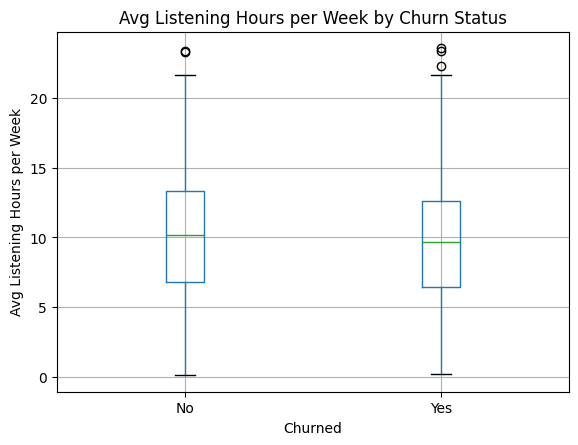

In [10]:
df.boxplot(column = "avg_listening_hours_per_week", by = "churned")
plt.title("Avg Listening Hours per Week by Churn Status")
plt.suptitle("")
plt.xlabel("Churned")
plt.ylabel("Avg Listening Hours per Week")
plt.show()